In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal 
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from packaging import version
import sklearn
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.__version__)
print(tf.executing_eagerly())
tf.config.run_functions_eagerly(True)

df = pd.read_excel("/home/jui/thesis-code/data/credit_card_clients.xls")
df['default payment next month'].value_counts()
print(df.shape)

2025-03-12 12:07:03.934596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741806423.948459 1423075 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741806423.952672 1423075 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 12:07:03.966888: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0
True
(30000, 25)


In [3]:
from raimitigations.dataprocessing import Rebalance  

df['EDUCATION'] = df['EDUCATION'].replace({1: 1, 2: 1, 3: 2, 4: 3})

bins = [0, 25, 35, 45, 55, 70, float('inf')]  # Define bin edges
labels = [1, 2, 3, 4, 5, 6]  # Assign category labels

df['AGE'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False).astype(int)

df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})

df = df.drop(columns=['ID'])

# Count occurrences of each unique value across all PAY_* columns
value_counts = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].stack().value_counts()

# List of columns to modify
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Replace -2 with -1
df[pay_columns] = df[pay_columns].replace({-2:-1})

rebalance = Rebalance(
				df=df,
				rebalance_col='SEX',
				k_neighbors=5,
				verbose=False
			)
df = rebalance.fit_resample()
print(df['SEX'].value_counts())

/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


2    18112
1    18112
Name: SEX, dtype: int64


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

class CGAN:
    def __init__(self, data_dim, latent_dim):
        self.data_dim = data_dim  # Dimension of the data (1 for binary column)
        self.latent_dim = latent_dim  # Dimension of the noise vector
        self.num_classes = 2  # Binary classification (0 and 1)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00035, beta_1=0.45), metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the combined model
        self.combined = self.build_combined()

    def build_generator(self):
        noise_input = Input(shape=(self.latent_dim,))
        label_input = Input(shape=(1,), dtype=tf.int32)

        # Embedding for class labels
        label_embedding = Embedding(input_dim=self.num_classes, output_dim=self.latent_dim)(label_input)
        label_embedding = Flatten()(label_embedding)

        # Concatenate noise and label embedding
        model_input = Concatenate()([noise_input, label_embedding])

        # Generator network
        x = Dense(128)(model_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)

        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)

        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)

        # Output layer with sigmoid activation for binary values
        output = Dense(self.data_dim, activation='sigmoid')(x)  # data_dim = sequence_length

        return Model([noise_input, label_input], output)

    def build_discriminator(self):
        data_input = Input(shape=(self.data_dim,))  # data_dim = sequence_length
        label_input = Input(shape=(1,), dtype=tf.int32)

        # Embedding for class labels
        label_embedding = Embedding(input_dim=self.num_classes, output_dim=self.data_dim)(label_input)
        label_embedding = Flatten()(label_embedding)

        # Concatenate data and label embedding
        model_input = Concatenate()([data_input, label_embedding])

        # Discriminator network
        x = Dense(512)(model_input)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
        x = BatchNormalization()(x)

        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
        x = BatchNormalization()(x)

        x = Dense(128)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
        x = BatchNormalization()(x)

        # Output layer with sigmoid activation
        validity = Dense(1, activation='sigmoid')(x)

        return Model([data_input, label_input], validity)

    def build_combined(self):
        # For the combined model, we only train the generator
        self.discriminator.trainable = False

        # Inputs
        noise_input = Input(shape=(self.latent_dim,))
        label_input = Input(shape=(1,), dtype=tf.int32)

        # Generate data based on noise and label
        generated_data = self.generator([noise_input, label_input])

        # Determine validity of generated data
        validity = self.discriminator([generated_data, label_input])

        # The combined model takes noise and label as input and outputs validity
        model = Model([noise_input, label_input], validity)
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005, beta_1=0.5))

        return model

    def train(self, X_train, y_train, epochs, batch_size=64, sample_interval=100):
        # Normalize data to [0, 1]
        X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())

        # Adversarial ground truths with label smoothing
        valid = np.ones((batch_size, 1)) * 0.9
        fake = np.zeros((batch_size, 1)) + 0.1

        # Arrays to store losses for plotting
        d_losses = []
        g_losses = []

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of real samples
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_samples = X_train[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            # Generate a batch of fake samples
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_labels = np.ones((batch_size, 1))  # Generate class 1 samples
            generated_samples = self.generator.predict([noise, gen_labels], verbose=0)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([real_samples, real_labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([generated_samples, gen_labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Generate a batch of noise and labels
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_labels = np.ones((batch_size, 1))  # Generate class 1 samples

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, gen_labels], valid)

            # Store losses for plotting
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)

            # Display progress
            if epoch % sample_interval == 0:
                print(f"[{epoch}/{epochs}] D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.1f}%, G Loss: {g_loss:.4f}")

        # Plot losses after training
        self.plot_losses(d_losses, g_losses)

    def generate_samples(self, num_samples, target_class=1):
        """Generate synthetic samples for the target class"""
        noise = np.random.normal(0, 1, (num_samples, self.latent_dim))
        labels = np.full((num_samples, 1), target_class)
        generated_samples = self.generator.predict([noise, labels], verbose=0)

        # Threshold to get binary values
        generated_samples = (generated_samples > 0.5).astype(int)
        return generated_samples, labels

    def balance_dataset(self, X_train, y_train, target_ratio=0.5):
        """Balance dataset by generating synthetic examples of the minority class"""
        class_counts = np.bincount(y_train.flatten())
        total_samples = len(y_train)

        # Calculate current class distribution
        class_dist = class_counts / total_samples

        # If class 1 (positive class) is less than target ratio
        if class_dist[1] < target_ratio:
            # Calculate how many samples we need to generate
            samples_needed = int((target_ratio * total_samples - class_counts[1]) / (1 - target_ratio))

            # Generate synthetic samples
            gen_samples, gen_labels = self.generate_samples(samples_needed, target_class=1)

            # Combine with original dataset
            X_balanced = np.vstack([X_train, gen_samples])
            y_balanced = np.vstack([y_train.reshape(-1, 1), gen_labels])

            print(f"Generated {samples_needed} samples for class 1")
            print(f"Original distribution: {class_dist}")
            print(f"New distribution: {np.bincount(y_balanced.flatten()) / len(y_balanced)}")

            return X_balanced, y_balanced
        else:
            print("Dataset already balanced according to target ratio")
            return X_train, y_train
        
    def plot_losses(self, d_losses, g_losses):
        """Plot the discriminator and generator losses"""
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label="Discriminator Loss", alpha=0.7)
        plt.plot(g_losses, label="Generator Loss", alpha=0.7)
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [6]:

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

# Handle different scikit-learn versions for OneHotEncoder parameters
if version.parse(sklearn.__version__) < version.parse('1.2'):
    ohe_params = {"sparse": False}
else:
    ohe_params = {"sparse_output": False}

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.select_dtypes(include=['int64', 'float64', 'float32']).columns.tolist(),
        'cat_cols': X.select_dtypes(include=['object']).columns.tolist(),
    }
    print("Numerical columns:", pipe_cfg['num_cols'])
    print("Categorical columns:", pipe_cfg['cat_cols'])
    num_pipe = Pipeline([ 
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', **ohe_params))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    # Using XGBClassifier with Regularization, Learning Rate, and Eval Metrics
    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Fast histogram-based training
        random_state=10,
        n_jobs=-1,  # Use all CPU cores
        learning_rate=0.16,  # Controls step size
        reg_lambda=1.1,  # L2 regularization (weight decay)
        eval_metric='logloss',
        objective='binary:logistic',  # Logarithmic loss for classification
        use_label_encoder=False,  # Avoids unnecessary warnings
        n_estimators=125
    )

    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', xgb_model)])

    return pipeline

(27168, 23)
Numerical columns: ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX']
Categorical columns: []


/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:12:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.8433
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7297
           1       0.67      0.38      0.48      1759

    accuracy                           0.84      9056
   macro avg       0.77      0.67      0.70      9056
weighted avg       0.83      0.84      0.83      9056


Final Training Log Loss: 0.2908
Final Test Log Loss: 0.3912
After conversion - Shape: (27168,), Dtype: int64
First few values after conversion: [0 0 0 0 0]
Class distribution: Class 0: 21806, Class 1: 5362


/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


[0/900] D Loss: 0.6972, D Acc: 0.0%, G Loss: 0.7403
[100/900] D Loss: 0.6870, D Acc: 0.0%, G Loss: 0.7253
[200/900] D Loss: 0.6944, D Acc: 0.0%, G Loss: 0.7120
[300/900] D Loss: 0.7017, D Acc: 0.0%, G Loss: 0.6996
[400/900] D Loss: 0.7074, D Acc: 0.0%, G Loss: 0.6893
[500/900] D Loss: 0.7119, D Acc: 0.0%, G Loss: 0.6818
[600/900] D Loss: 0.7152, D Acc: 0.0%, G Loss: 0.6759
[700/900] D Loss: 0.7176, D Acc: 0.0%, G Loss: 0.6717
[800/900] D Loss: 0.7196, D Acc: 0.0%, G Loss: 0.6683


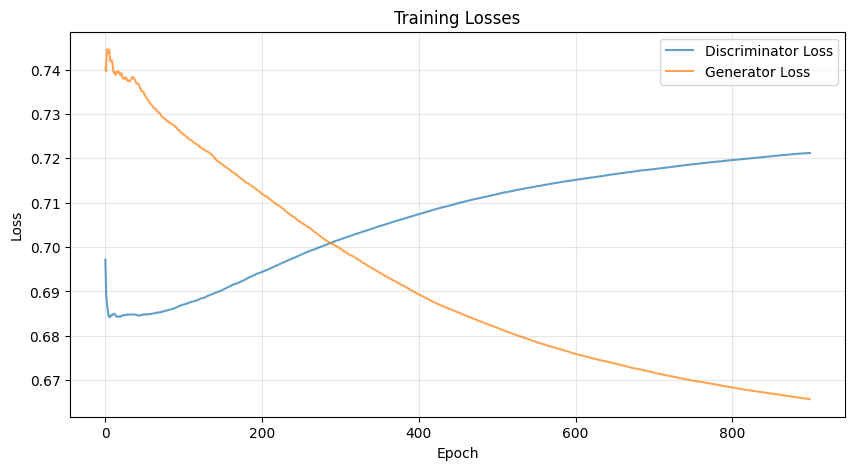

Generated 16444 samples for class 1
Original distribution: [0.80263545 0.19736455]
New distribution: [0.5 0.5]
Generated 7000 synthetic samples for class 1 (default payment)


In [9]:
target_feature = 'default payment next month'
categorical_features = []

# Split data into features and target
X, y = split_label(df, target_feature)

# Split data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
print(X_train.shape)

features = X_train.columns.tolist()  
classes = np.unique(y_train).tolist() 

# Create the classification pipeline
pipeline = create_classification_pipeline(X_train)

# Fit the preprocessor separately to extract feature names
pipeline.named_steps['preprocessor'].fit(X_train)

# Extract transformed feature names safely
if hasattr(pipeline.named_steps['preprocessor'], "get_feature_names_out"):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
else:
    # Manually construct feature names (for older sklearn versions)
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    feature_names = num_cols + cat_cols  # Not perfect, but works if get_feature_names_out() is missing

# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Extract XGBClassifier separately and fit with eval_set
xgb_model = pipeline.named_steps['model']
model = xgb_model.fit(pipeline.named_steps['preprocessor'].transform(X_train), y_train, 
              eval_set=[(pipeline.named_steps['preprocessor'].transform(X_train), y_train),
                        (pipeline.named_steps['preprocessor'].transform(X_test), y_test)], verbose=False)

# Make predictions
y_pred = xgb_model.predict(pipeline.named_steps['preprocessor'].transform(X_test))
# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Convert y_train to a simple 1D array of integers
y_train_flat = np.ravel(y_train).astype(int)

print(f"After conversion - Shape: {y_train_flat.shape}, Dtype: {y_train_flat.dtype}")
print(f"First few values after conversion: {y_train_flat[:5]}")

# Now try bincount with the flattened array
class_counts = np.bincount(y_train_flat)
print(f"Class distribution: Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")

# Make a clean copy of X_train as a simple 2D array
X_train_array = np.array(X_train, dtype=np.float32)

# Initialize the CGAN
data_dim = X_train_array.shape[1]  # Number of features
latent_dim = 120  # Size of noise vector

# Initialize and train the CGAN
cgan = CGAN(data_dim, latent_dim=latent_dim)

X_train_array = (X_train_array - X_train_array.min()) / (X_train_array.max() - X_train_array.min()) 

# Train the model
cgan.train(X_train_array, y_train_flat, epochs=900, batch_size=64, sample_interval=100)

X_balanced, y_balanced = cgan.balance_dataset(X_train, y_train, target_ratio=0.5)

# Generate synthetic samples for the minority class
n_synthetic = 7000
synthetic_samples, synthetic_labels = cgan.generate_samples(num_samples=n_synthetic, target_class=1)

print(f"Generated {n_synthetic} synthetic samples for class 1 (default payment)")

# Combine with original dataset
X_augmented = np.vstack([X_train_array, synthetic_samples])
y_augmented = np.concatenate([y_train_flat, synthetic_labels.flatten()])



Numerical columns: ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX']
Categorical columns: []
X_train_transformed shape: (34168, 23)
X_test_transformed shape: (9056, 23)
Column names and data types in X_augmented_df:
LIMIT_BAL    float64
EDUCATION    float64
MARRIAGE     float64
AGE          float64
PAY_0        float64
PAY_2        float64
PAY_3        float64
PAY_4        float64
PAY_5        float64
PAY_6        float64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
SEX          float64
dtype: object


/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:16:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.7872
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.86      7297
           1       0.46      0.55      0.50      1759

    accuracy                           0.79      9056
   macro avg       0.67      0.70      0.68      9056
weighted avg       0.80      0.79      0.79      9056


Final Training Log Loss: 0.2404
Final Test Log Loss: 0.9368


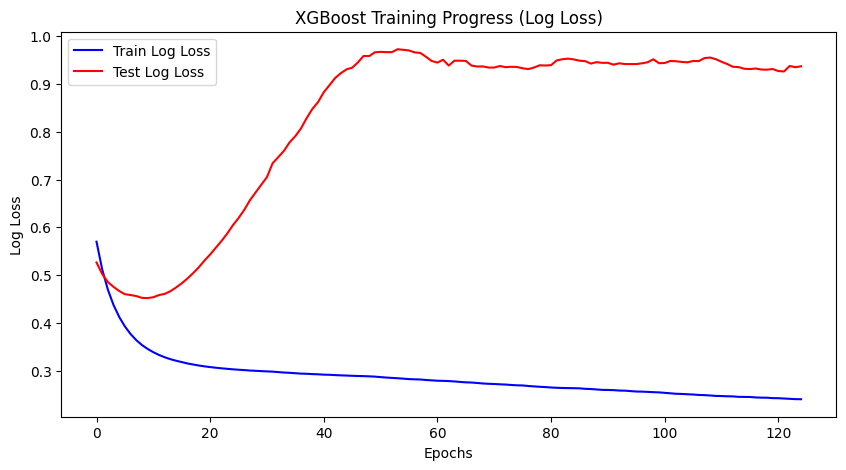

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse

# Convert X_augmented to a DataFrame
X_augmented_df = pd.DataFrame(X_augmented, columns=features)

# Create the classification pipeline
pipeline = create_classification_pipeline(X_augmented_df)

# Fit the preprocessor separately to extract feature names
preprocessor = pipeline.named_steps['preprocessor']
preprocessor.fit(X_augmented_df)

# Apply transformations
X_train_transformed = preprocessor.transform(X_augmented_df)
X_test_transformed = preprocessor.transform(X_test)

# Check the shapes of the transformed data
print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"X_test_transformed shape: {X_test_transformed.shape}")

# Convert sparse matrices to dense arrays if necessary
if issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()
if issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

# Ensure y_augmented and y_test are NumPy arrays
if isinstance(y_augmented, pd.Series):
    y_augmented = y_augmented.to_numpy()
if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy()

# Prepare eval_set
eval_set = [
    (X_train_transformed, y_augmented),  # Training data
    (X_test_transformed, y_test)         # Test data
]

# Fit the XGBoost model
xgb_model = pipeline.named_steps['model']
model = xgb_model.fit(
    X_train_transformed, y_augmented,
    eval_set=eval_set,
    verbose=False
)

# Make predictions
y_pred = xgb_model.predict(preprocessor.transform(X_test))

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Plot training and validation log loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['logloss'], label='Train Log Loss', color='blue')
plt.plot(evals_result['validation_1']['logloss'], label='Test Log Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Progress (Log Loss)")
plt.legend()
plt.show()

In [22]:
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights

In [ ]:
from responsibleai.feature_metadata import FeatureMetadata
import seaborn as sns
import matplotlib.pyplot as plt

# Set up feature metadata for RAIInsights
feature_metadata = FeatureMetadata(categorical_features=categorical_features, dropped_features=[])

# Add the target feature back to the datasets
X_train_og_with_target = X_train_og.copy()
X_train_og_with_target[target_feature] = y_train

X_test_og_with_target = X_test_og.copy()
X_test_og_with_target[target_feature] = y_test

#X_test_og_with_target = X_test_og_with_target.sample(n=5000, random_state=10)

# Specify the stratification variable
stratify_by = 'AGE'

# Split the data into training and testing sets, with stratification
train, test = train_test_split(X_train_og_with_target, test_size=0.3, stratify=X_train_og_with_target[stratify_by])
sample_df, _ = train_test_split(
    train, 
    train_size=5000/len(train),  # Ensure we get exactly 5000 samples
    stratify=train[stratify_by],  # Maintain distribution
    random_state=42
)

# Check the distribution of the stratification variable in the training and testing sets
print("Train dataset:\n", sample_df[stratify_by].value_counts())

Train dataset:
 2    2244
3    1523
4     647
1     436
5     146
6       4
Name: AGE, dtype: int64


'\nkey_column = num_cols[6] \n\n# Ensure no missing values in the key column\ndf = df.dropna(subset=[key_column])\n\n# Debug: Check key column\nprint(f"Using key column for stratification: {key_column}")\nprint(f"Dataset shape before binning: {df.shape}")\n\n# Create bins for stratification\ndf["bin"] = pd.qcut(df[key_column], q=10, labels=False, duplicates="drop")\n\n# Debug: Check unique bins\nprint("Unique bins created:", df["bin"].nunique())\n\n# Stratified sampling\nsampled_df, _ = train_test_split(df, train_size=5000/len(df), stratify=df["bin"], random_state=42)\n\n# Drop the \'bin\' column **only from the sampled_df**\nsampled_df = sampled_df.drop(columns=["bin"])\ndf = df.drop(columns=["bin"])\n\n# Debug: Check sampled dataset shape\nprint("Sampled Dataset Shape:", sampled_df.shape)\n\n\n# Select a key numerical column for stratification (modify based on your dataset)\nkey_column = df.columns[1]  # Choose the first column or another important numeric feature\n\n# Create bins us

In [24]:
# Now, pass these modified DataFrames to RAIInsights
rai_insights = RAIInsights(model, X_train_og_with_target, sample_df, target_feature, 'classification', feature_metadata=feature_metadata)

In [25]:
# Interpretability
rai_insights.explainer.add()
# Error Analysis
rai_insights.error_analysis.add()

# Counterfactuals: accepts total number of counterfactuals to generate, the label that they should have, and a list of 
                # strings of categorical feature names
#rai_insights.counterfactual.add(total_CFs=10, desired_class='opposite')


In [26]:
# Compute: Perform all tasks (this remains CPU-bound)
rai_insights.compute()

Causal Effects
Current Status: Generating Causal Effects.
Current Status: Finished generating causal effects.
Time taken: 0.0 min 1.9534025341272354e-05 sec
Counterfactual
Time taken: 0.0 min 6.1549944803118706e-06 sec
Error Analysis
Current Status: Generating error analysis reports.
Current Status: Finished generating error analysis reports.
Time taken: 0.0 min 0.33981222892180085 sec
Explanations
Current Status: Explaining 23 features
Current Status: Explained 23 features.
Time taken: 0.0 min 0.9517165520228446 sec


In [27]:
ResponsibleAIDashboard(rai_insights)

ResponsibleAI started at http://localhost:8705
